# Calculate the correlations for each layer and create input RDMs

## Set up the environment

In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn

## Define the function to create filenames

In [2]:
def getFileName(n_samples, name):
    return name \
        + "_{}_".format(n_samples) \
        + "_{}_".format(model_name) \
        + "_{}".format(layer_name)   \
        + ".npy"       

## Select the model and layer

In [3]:
ROOT_PATH = '/mnt/raid/ni/agnessa/RSA/Scenes/ImageNet'
layers_path = '/mnt/raid/ni/agnessa/RSA/'
NR_OF_SAMPLES = 10000
#load json file with the layers of interest 
arch = 'alexnet'
json_file_layers=os.path.join(layers_path + '/layer_names/',arch + '.json')

#for resnets, use the selected layers file
if 'res' in arch:
    json_file_layers=os.path.join(layers_path + '/layer_names/',arch + '_selected_layers.json')
with open(json_file_layers, "r") as fd:
    selected_layers = json.load(fd)
model_name, layer_name = selected_layers[13].get('model'),  selected_layers[13].get('layer') #change the index at each iteration


## Define the correlation function

In [4]:
def correlationd_matrix(batch_size): #(list_of_activations, n) ,array_activations
    file_name = os.path.join(ROOT_PATH+'/activations/',getFileName(NR_OF_SAMPLES,'activations'))
    act = np.load(file_name,mmap_mode='r') #mmap is used to access a part of the file 
    correlationd = np.zeros((NR_OF_SAMPLES,NR_OF_SAMPLES))
    correlationd[:] = np.nan
    num_batches = int(NR_OF_SAMPLES / batch_size)
    total = sum(x+1 for x in range(num_batches)) #num 1000-wise comparisons to do: 55
    index = 0
   
    for i in range(num_batches): #[0:9[
        start_1 = batch_size*i
        end_1 = batch_size*(i+1)
        list_of_activations_1 = act[start_1:end_1,:]

        for j in range(i,num_batches): #[i:10[
            index += 1
            print("New Iteration: i = {0}, j = {1}; {2}/{3}".format(i,j,index,total))
            start_2 = batch_size*(j)
            end_2 = batch_size*(j+1)
            list_of_activations_2 = act[start_2:end_2,:]
            corr_activations = 1-np.corrcoef(list_of_activations_1,list_of_activations_2) #2000 x 2000 matrix

            for x in range(corr_activations.shape[0]):
                for y in range(corr_activations.shape[1]):
                    if x < batch_size:
                        start_x = start_1
                    else: 
                        start_x = start_2-1000
                    if y < batch_size:
                        start_y = start_1
                    else:
                        start_y = start_2-1000                       
                    correlationd[x+start_x,y+start_y] = correlationd[y+start_y,x+start_x] = corr_activations[x,y]

    return(correlationd)

Calculating the correlations for model:  alexnet and layer:  features.11
New Iteration: i = 0, j = 0; 1/55
New Iteration: i = 0, j = 1; 2/55
New Iteration: i = 0, j = 2; 3/55
New Iteration: i = 0, j = 3; 4/55
New Iteration: i = 0, j = 4; 5/55
New Iteration: i = 0, j = 5; 6/55
New Iteration: i = 0, j = 6; 7/55
New Iteration: i = 0, j = 7; 8/55
New Iteration: i = 0, j = 8; 9/55
New Iteration: i = 0, j = 9; 10/55
New Iteration: i = 1, j = 1; 11/55
New Iteration: i = 1, j = 2; 12/55
New Iteration: i = 1, j = 3; 13/55
New Iteration: i = 1, j = 4; 14/55
New Iteration: i = 1, j = 5; 15/55
New Iteration: i = 1, j = 6; 16/55
New Iteration: i = 1, j = 7; 17/55
New Iteration: i = 1, j = 8; 18/55
New Iteration: i = 1, j = 9; 19/55
New Iteration: i = 2, j = 2; 20/55
New Iteration: i = 2, j = 3; 21/55
New Iteration: i = 2, j = 4; 22/55
New Iteration: i = 2, j = 5; 23/55
New Iteration: i = 2, j = 6; 24/55
New Iteration: i = 2, j = 7; 25/55
New Iteration: i = 2, j = 8; 26/55
New Iteration: i = 2, j = 

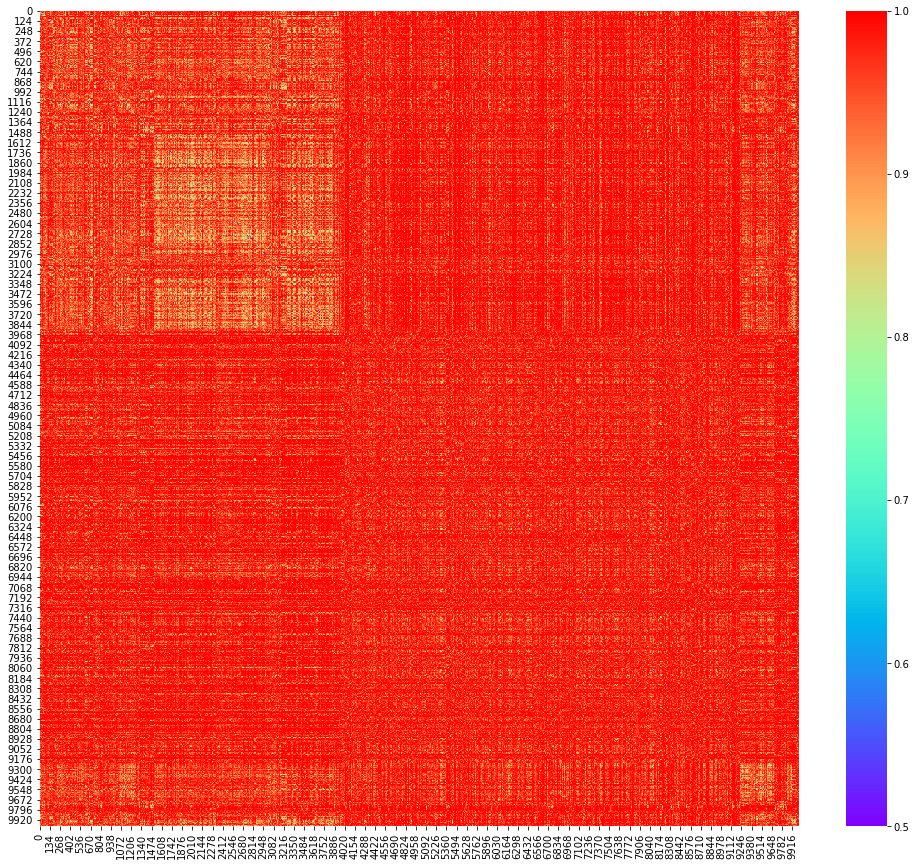

In [5]:
print('Calculating the correlations for model: ',model_name,'and layer: ',layer_name)
corr_matrix = correlationd_matrix(1000) 
path = os.path.join(ROOT_PATH + '/Input_RDM/', getFileName(NR_OF_SAMPLES, "Input_RDM_"))
print("Save Input RDM -> {}".format(path))
np.save(path, np.array(corr_matrix)) 
fig = plt.figure(figsize=(17,15))
ax = seaborn.heatmap(corr_matrix, cmap='rainbow', vmin=0.5, vmax=1.0)
path_fig = os.path.join(ROOT_PATH + '/Input_RDM_plots', getFileName(NR_OF_SAMPLES,"Input_RDM_") + '.png')
fig.savefig(path_fig)

## In case the load function does not work

In [ ]:
#If the load function gives an error, do this
np_load_old = np.load # modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
activations_shape = np.load(path)
np.load = np_load_old